# Tutorial:ベイズ最適化

## はじめに
- Python ライブラリを使ってベイズ最適化を実装する
- 課題：ある実験を実施する際に、可能な限り少ない試行回数で、目標性能にたどりつきたい
- やりたいこと：予備実験の結果を元に、ベイズ最適化を使って、筋の良い実験条件を提示したい

## ベイズ最適化のライブラリ
いくつかあるけど、可視化の方法がいろいろ充実していそうだったので、[scikit-optimize](https://scikit-optimize.github.io/stable/install.html) でまずは試してみることにした。

- [scikit-optimize](https://scikit-optimize.github.io/stable/) の Bayesian optimization
    - New York University などのグループによる
    - github の Star は2.2k（21年8月時点）
    - BSD-3-Clause License
- [BayesianOptimization](https://github.com/fmfn/BayesianOptimization)
    - Fernando Nogueira(PhD, 現在はShopify データサイエンティスト）による
    - github の Star は5.3k（21年8月時点）
    - MIT License
- [GpyOpt](https://github.com/SheffieldML/GPyOpt):
    - Sheffield 大学の研究グループによる、21年8月時点でメンテは終了
    - 同グループは、ガウス過程回帰のライブラリ Gpy もリリース
    - github の Star 数は756（21年8月時点）
    - BSD-3-Clause License
- [COMBO](https://github.com/tsudalab/combo)
    - 東京大学、材料向け
    - github の Star 数は 117（21年8月時点）
    - MIT License
- [PHYSBO](https://www.pasums.issp.u-tokyo.ac.jp/physbo/)
    - 東京大学、物性研究所
    - github の Star 数は 17（21年9月時点）
    - GPL v3
    


## 例題：まずは動かしてみる

ソース:[Bayesian optimization with skopt](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html)


ランダムノイズを持つ関数 $ f(x) $ を目的関数にして、ベイズ最適化を使って、最適値を探索する。

In [1]:
import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

In [2]:
noise_level = 0.1

def f(x, noise_level=0.0):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

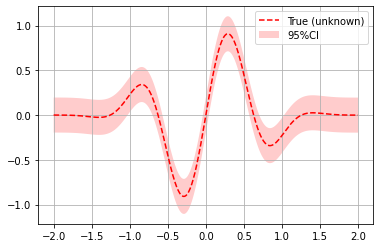

In [3]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]), # x[::-1] は行の順序を反転する
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None", label='95%CI')
plt.legend()
plt.grid()
plt.show()

**注意** scikit-optimize では、関数 $f$は1次元のベクトル$x$を入力として、スカラーを返す

最適化を実行する。

In [24]:
from skopt import gp_minimize

result = gp_minimize(f,               # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=10,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)  # the random seed

### クラス `gp_minimize` の引数（親クラス `Optimizer` の子クラス）

| 引数 | 型 | 説明 | デフォルト |
| --- | --- | --- | --- |
| func | _callable_ | **最小化**したい関数。説明変数を_list_を入力し、目的変数をscalarで返す。 |  |
| dimensions | _list_ | 説明変数の長さの_list_。実数や整数値の場合は、(`下限値, 上限値`)の _tuple_。カテゴリ変数の場合は、カテゴリの_list_。| |
| base_estimator | a Gaussian process estimator | 最適化に用いるガウス過程回帰モデル。デフォルトでは Matern kernel。| |
| n_calls | _int_ | `func`の呼び出し回数。 | 100 |
| n_random_starts | _int_ | 初期値を得るための `func` の評価回数。version 0.8 以降はn_initial_points 使用を推奨。 | None |
| n_initial_points | _int_ | 初期値を得るための `func` の評価回数。 | 10 |
| intial_point_generator | _str, InitialPointGenerator instance_ | 初期値の生成方法。`'random', 'sobol', 'halton', 'hammersly', 'lhs'`より指定。  | 'random' |
| acq_func | _string_ | 目的変数を最小化するために使用する獲得関数。`'LCB', 'EI', 'PI', 'gp_hedge', 'EIps', 'PIps' `より指定。 | 'gp_hedge'|
| acq_optimizer | _string_ | 獲得関数を最小化するための方法。この方法で、`n_points` 回ランダムサンプリングされた点で`acq_func` を計算する。`'auto', 'sampling', 'lbfgs'`より指定。`sampling` だと、`n_points` で計算したサンプリング点の中から、最小になる点を最適解とする。`lbfgs`は、`n_restarts_optimizer` で指定された、獲得関数が最も小さくなる複数のデータ点を開始点とし、局所解を探索することを20回繰り返す。  | 'lfbgs' | 
| x0 | _list, list of lists, None_ | 説明変数の初期値。 | `None` |
| y0 | _list, scalar, None_ | 目的変数の初期値。 | `None` |
| random_state | int, RandomState instance | 乱数のシード。 | None |
| verbose | boolean |  | False |
| callback | callable, list of callables| | |
| n_points | int | 最適解を探索するためにサンプリングする回数。 | 10000 |
| n_restarts_optimizer | int | 獲得関数の最適化で `lbfgs` を使用する場合の、初期点サンプリング数。| 5 |
| kappa | float | 最適解を探索する際にどの程度分散を考慮に入れるべきか設定値。値が大きいと探索重視に、小さいと活用重視になる。獲得関数が`'LCB'`の場合に使用。 | 1.96 |
| xi | float | 目的変数の改善度合の目標値。獲得関数が`'EI'`または`'PI'`の場合に使用。 | 0.01 |
| noise | float | 目的関数のノイズの設定。`gaussian` を指定した場合は、目的関数の観測値は、平均0で分散が一定のiidのランダムノイズを含むものとして取り扱う。目的関数に含まれるノイズが小さい場合には、ゼロに近い値を設定する（`1e-10`）。| 'gaussian'|

試行した $x$ の値

In [5]:
result.x_iters

[[-0.009345334109402526],
 [1.2713537644662787],
 [0.4484475787090836],
 [1.0854396754496047],
 [1.4426790855107496],
 [-0.26342394160296734],
 [-0.43805003457196134],
 [-0.30601964616510213],
 [-2.0],
 [-1.1412455072181535]]

対応する $f(x)$ の値

In [6]:
result.func_vals.tolist()

[-0.04670558930848328,
 0.005580573596464258,
 0.6275640344997435,
 -0.1307459167788306,
 0.02457786312288232,
 -0.9009325096820255,
 -0.659851163378018,
 -0.9058740485502136,
 0.00036487510102654235,
 0.07508469652022576]

$f(x)$ を最大化する $x^*$ と $f(x^*)$

In [7]:
"x^*=%.4f, f(x^*)=%.4f" % (result.x[0], result.fun)

'x^*=-0.3060, f(x^*)=-0.9059'

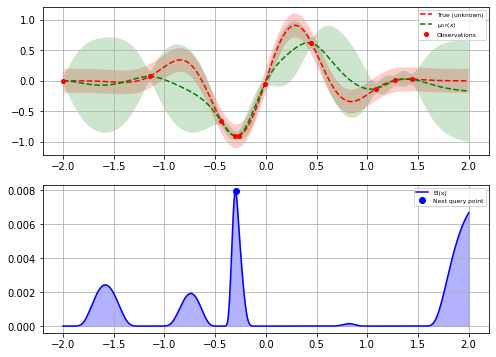

In [23]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
ax = plot_gaussian_process(result, objective=f,noise_level=noise_level,
                           show_legend=True, show_title=False,
                           show_next_point=False,
                           show_acq_func=False)
ax.set_ylabel("")
ax.set_xlabel("")

# Plot EI(x)
plt.subplot(2, 1, 2)
ax = plot_gaussian_process(result,
                           show_legend=True, show_title=False,
                           show_mu=False, show_acq_func=True,
                           show_observations=False,
                           show_next_point=True)
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

解の収束過程を可視化する

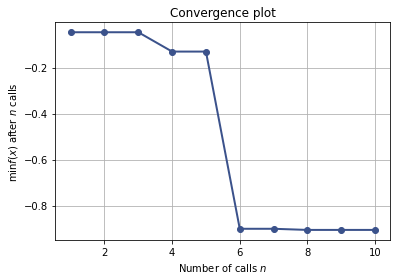

In [22]:
from skopt.plots import plot_convergence
plot_convergence(result);

## 評価関数が未知の場合

実際には、最適解したい関数 $f$ は未知なので、初期値のデータセットのみで学習し、次の探索点 $x^*$ と $f(x^*)$ を出力するようにする

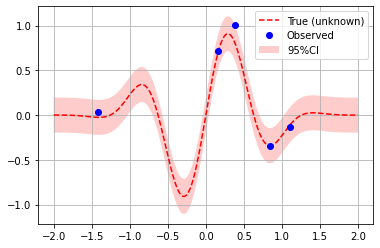

In [8]:
x_init = np.random.rand(5).reshape(-1, 1)*4 - 2 # -2 ~ 2 の一様乱数
fx_init = [f(x_i, noise_level=0.1) for x_i in x_init]

plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None", label='95%CI')

plt.plot(x_init, fx_init, "bo", label="Observed")

plt.legend()
plt.grid()
plt.show()

青の点が初期値として与えられているとする

初期値だけで学習して、探索はしないようにするために、`n_call=0, n_random_starts=0` として、初期値の `x0, y0` を与える

| 引数 | 型 | 説明 | デフォルト |
| --- | --- | --- | --- |
| n_calls | _int_ | `func`の呼び出し回数 | 100 |
| n_initial_points | _int_ | 初期値を得るための `func` の評価回数 | 10 |
| x0 | _list, list of lists, None_ | 説明変数の初期値 | `None` |
| y0 | _list, scalar, None_ | 目的変数の初期値 | `None` |


In [11]:
res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=0,          # the number of evaluations of f
                  n_initial_points=0,  # the number of random initialization points
                  x0=x_init.tolist(), # initial input points
                  y0=fx_init,         # Objective values at initial input points
                  #noise=0.1**2,      # the noise level (optional)
                  random_state=1234)  # the random seed

モデルパラメータの確認

In [12]:
res.specs

{'args': {'func': <function __main__.f(x, noise_level=0.0)>,
  'dimensions': Space([Real(low=-2.0, high=2.0, prior='uniform', transform='normalize')]),
  'base_estimator': GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5),
                           n_restarts_optimizer=2, noise='gaussian',
                           normalize_y=True, random_state=822569775),
  'n_calls': 0,
  'n_random_starts': None,
  'n_initial_points': 0,
  'initial_point_generator': 'random',
  'acq_func': 'EI',
  'acq_optimizer': 'auto',
  'x0': [[0.8439574484783332],
   [0.15977933331743888],
   [0.3883924909531733],
   [-1.41378896397074],
   [1.1037068414396844]],
  'y0': [-0.34608198163672205,
   0.7180764075963657,
   1.003597286631642,
   0.03598904810444822,
   -0.13280655468351119],
  'random_state': RandomState(MT19937) at 0x7F3DC0C27490,
  'verbose': False,
  'callback': None,
  'n_points': 10000,
  'n_restarts_optimizer': 5,
  'xi': 0.01,
  'kappa': 1.96,
  'n_jobs': 1,
  'model_que

$f(x)$ を最大化する $x^*$ と $f(x^*)$

In [13]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=0.8440, f(x^*)=-0.3461'

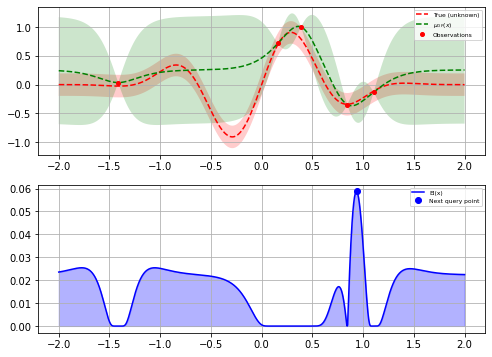

In [15]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
ax = plot_gaussian_process(res, objective=f,noise_level=noise_level,
                           show_legend=True, show_title=False,
                           show_next_point=False,
                           show_acq_func=False)
ax.set_ylabel("")
ax.set_xlabel("")

# Plot EI(x)
plt.subplot(2, 1, 2)
ax = plot_gaussian_process(res,
                           show_legend=True, show_title=False,
                           show_mu=False, show_acq_func=True,
                           show_observations=False,
                           show_next_point=True)
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

$x^*$ に対して、実験を行い、新たな観測値を得る

In [16]:
obs = f(res.x, noise_level=0.1)
obs

-0.22972981402552517

初期値に加える

In [17]:
x_init = np.append(x_init, np.array(res.x).reshape(1,x.shape[-1]), axis=0)
x_init

array([[ 0.84395745],
       [ 0.15977933],
       [ 0.38839249],
       [-1.41378896],
       [ 1.10370684],
       [ 0.84395745]])

In [18]:
fx_init.append(obs)
fx_init

[-0.34608198163672205,
 0.7180764075963657,
 1.003597286631642,
 0.03598904810444822,
 -0.13280655468351119,
 -0.22972981402552517]

初期値を更新して、再度学習を行い、最適解の探索を行う、を繰り返す

近似解の推定値は、初期値での学習のみなので、常に一定となる

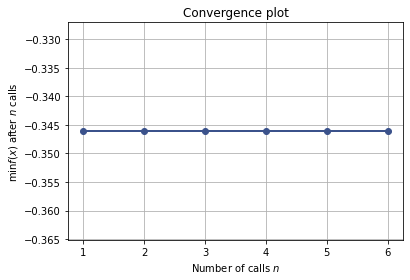

In [21]:
plot_convergence(res);

次にやりたいこと
- 探索と活用のバランス：パラメータの設定の戦略
- 獲得関数の性質比較
- 入力が多次元の場合。可視化の方法。

次の実験条件と実験結果を interactive に入力できるように、実験条件 x が与えられた時に、y の観測値を入力する関数も作ったが、Pythonつけっぱなしにしとくことはないので、使わない

In [66]:
def interactive_f(x:list):
    print("next x")
    for i, value in enumerate(x):
        print(str(i) + ":" + str(value))
    y_obs = float(input("Input y_obs : "))
    return y_obs

In [67]:
interactive_f(res.x)

next x
0:0.8439574484783332


Input y_obs :  0


0.0

参考にしたサイト
https://qiita.com/oki_kosuke/items/e68d5f68c972c3af32cc